In this notebook, we will consult the previous tensorflow sample code generated together with Edgar and basic knowledge of tensorflow to generate runnning version of BCM tensorflow training code. Our goal is to generate py files that is executable in tensorflow and hence GPU machine.

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import data_loader
import matplotlib.pyplot as plt
% matplotlib inline

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

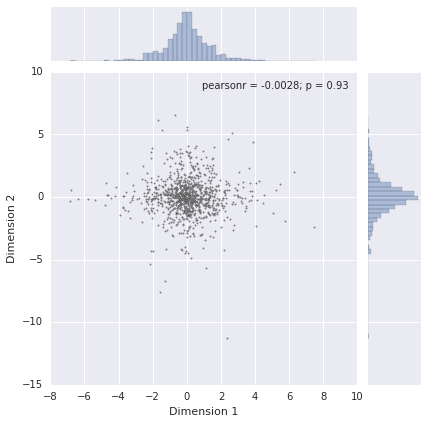

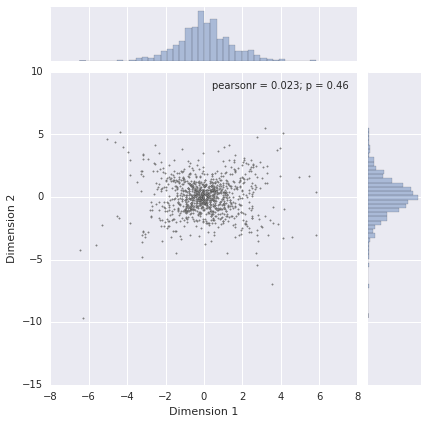

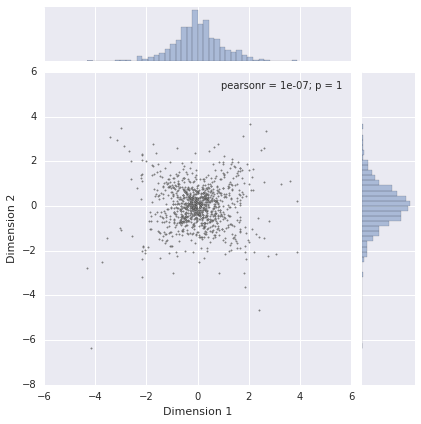

In [4]:
data, data_w = data_loader.load_laplace(loc = 0, scale = 1, sample_size = 1000,dimension = 2,skew = False, whiten = True, rotation = True)

In [13]:
dim_x = 2
n_output = 2
eta = 0.0005
decay = 0.01
p = 2
tau = 200
sample_size = data.shape[0]

# Give input place holder

input_value = tf.placeholder(tf.float32, [1, dim_x])
obj_input = tf.placeholder(tf.float32, [sample_size, dim_x])

# Varaible
w = tf.Variable(tf.random_normal([dim_x, n_output]))
threshold = tf.Variable(tf.zeros([1, n_output]))

### Computation steps
# Compute output with ReLU
net_input = tf.matmul(input_value, w)
output_value = tf.nn.relu(net_input)

# Update weights with QBCM learning rule
out_thre_diff = output_value - threshold
delta_w = eta * tf.matmul(input_value, tf.mul(output_value, out_thre_diff), transpose_a = True)- eta * decay * w
new_w = w + delta_w
update_w = tf.assign(w, new_w)

# Update threshold
h = tf.exp(-1/tau)
new_thres = threshold * h + tf.pow(output_value, p) * (1 - h)
update_thres = tf.assign(threshold, new_thres)

# Calculate QBCM objective function
obj_net_input = tf.matmul(obj_input, w)
obj_output = tf.nn.relu(obj_net_input)
obj1 = tf.reduce_mean(tf.pow(obj_output, 3))
obj2 = tf.reduce_mean(tf.pow(obj_output, 2))
obj = obj1/3 - tf.pow(obj2, 2)/4


In [28]:
# Train the model
epoch = 40

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

w_track = []
y_track = []
thres_track = []
for i in range(epoch):
    tf.random_shuffle(data)
    for j in range(data.shape[0]):
        sess.run(update_w, feed_dict = {input_value: data[j,:].reshape(1,2)})
        sess.run(update_thres, feed_dict = {input_value: data[j,:].reshape(1,2)})
        sess.run(obj, feed_dict = {obj_input: data})
        w_track.append(sess.run(w).reshape(1,4))
        thres_track.append(sess.run(threshold))

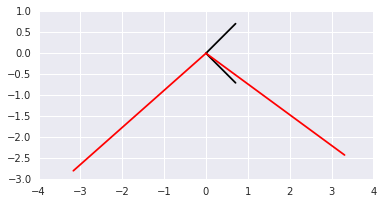

In [46]:
# Plot the final weight
final_w = sess.run(w).reshape(1,4)
plt.plot([0, data_w[0][0]], [0, data_w[0][1]], 'k')
plt.plot([0, data_w[1][0]], [0, data_w[1][1]], 'k')
g = plt.gca()
g.set_aspect(1)
plt.plot([0, final_w[0][0]], [0, final_w[0][1]], 'r')
plt.plot([0, final_w[0][2]], [0, final_w[0][3]], 'r')

In [ ]:
tf.random_normal()